## Set GPU

In [1]:
import torch
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = 'cpu'
print(f'{device=}')

NVIDIA A100-PCIE-40GB
device='cuda'


## Scipy example

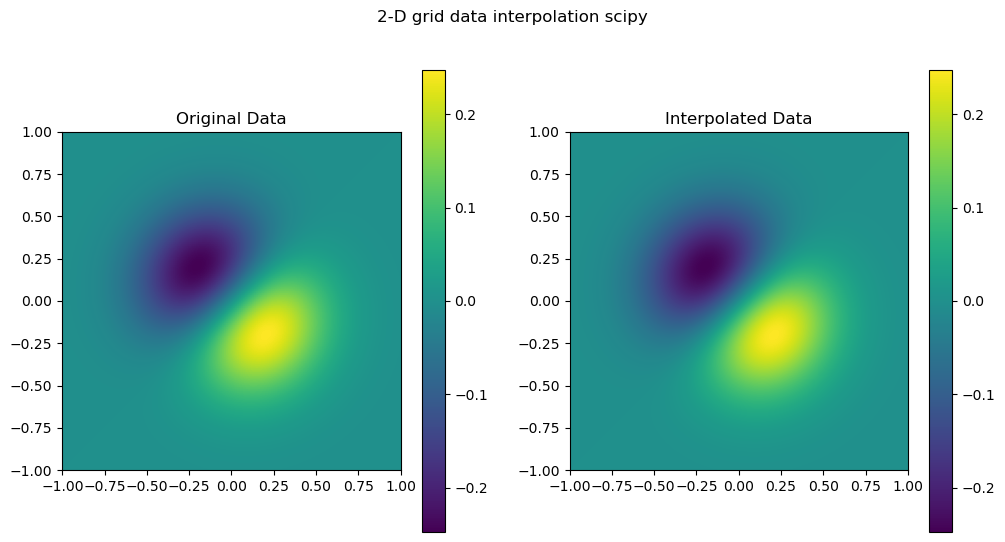

In [2]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt

# Generate data
x = np.linspace(-1, 1, 180)
y = np.linspace(-1, 1, 180)
x_grid, y_grid = np.meshgrid(x, y)
z = (x_grid + y_grid) * np.exp(-6.0 * (x_grid ** 2 + y_grid ** 2))

# Create RectBivariateSpline
f = RectBivariateSpline(x, y, z)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot original data
plt.subplot(1, 2, 1)
im = plt.imshow(z, extent=(x[0], x[-1], y[0], y[-1]))
plt.colorbar(im)
plt.title('Original Data')

# Interpolate onto a new grid
xnew = np.linspace(-1, 1, 400)
ynew = np.linspace(-1, 1, 400)
xnew_grid, ynew_grid = np.meshgrid(xnew, ynew)
znew = f(xnew, ynew)

# Plot interpolated data
plt.subplot(1, 2, 2)
im = plt.imshow(znew, extent=(xnew[0], xnew[-1], ynew[0], ynew[-1]))
plt.colorbar(im)
plt.title('Interpolated Data')

plt.suptitle('2-D grid data interpolation scipy')
plt.show()

## CPU for loop implementation

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
import torch.nn.functional as F

def generate_natural_knots(x, k):
    start=time.time()
    n = x.shape[0]
    t = torch.zeros(n + 2 * k, device=x.device)
    t[:k] = x[0]
    t[k:-k] = x
    t[-k:] = x[-1]
    end=time.time()
    print(f'Time for knot generation: {end-start}s')
    return t

def bspline_basis_natural(x, k, t):
    start=time.time()
    n = x.shape[0]
    m = t.shape[0] - k - 1

    b = torch.zeros((n, m, k + 1), device=x.device)

    # Initialize zeroth degree basis functions
    for j in range(m):
        b[:, j, 0] = ((t[j] <= x) & (x < t[j + 1])).float()

    # Handle boundary conditions at the first and last knot
    b[:, 0, 0] = torch.where(x < t[1], torch.ones_like(x), b[:, 0, 0])
    b[:, -1, 0] = torch.where(x >= t[-2], torch.ones_like(x), b[:, -1, 0])

    # Recursive definition of B-spline basis functions
    for d in range(1, k + 1):
        for j in range(m): 
                    
            left_num = x - t[j]
            left_den = t[j + d] - t[j]
            right_num = t[j + d + 1] - x
            right_den = t[j + d + 1] - t[j + 1]

            left = torch.zeros_like(left_num)
            right = torch.zeros_like(right_num)
            non_zero_left = left_den > 0
            non_zero_right = right_den > 0

            if non_zero_left.any():
                left[non_zero_left] = (left_num[non_zero_left] / left_den[non_zero_left]) * b[:, j, d - 1][non_zero_left]
            if non_zero_right.any():
                if j<m-1:
                    right[non_zero_right] = (right_num[non_zero_right] / right_den[non_zero_right]) * b[:, j + 1, d - 1][non_zero_right]

            b[:, j, d] = left + right
    
    end=time.time()
    print(f'Time for basis computation: {end-start}s')
    return b[:, :, -1]
    
    

def bivariate_spline_fit_natural(x, y, z, kx, ky, s):
    start=time.time()
    # Generate knots for x and y
    tx = generate_natural_knots(x, kx)
    ty = generate_natural_knots(y, ky)

    # Compute B-spline basis functions for x and y
    bx = bspline_basis_natural(x, kx, tx)
    by = bspline_basis_natural(y, ky, ty)

    # Compute the tensor product of basis functions
    BxBy = torch.einsum('ij,kl->ikjl', bx, by).view(-1, bx.size(1) * by.size(1))

    # Flatten the z values for least-squares fitting
    z_flat = z.view(-1)

    # Add boundary condition constraints
    m = BxBy.size(1)
    I = torch.eye(m, device=BxBy.device)
    C = torch.zeros(m, m, device=BxBy.device)

    # Constrain second derivatives to be zero at boundaries
    for i in range(1, kx):
        C[i, i] = 1
        C[-i, -i] = 1
    for j in range(1, ky):
        C[j * bx.size(1), j * bx.size(1)] = 1
        C[-j * bx.size(1), -j * bx.size(1)] = 1

    B_T_B = BxBy.T @ BxBy + s * (I + C)
    B_T_z = BxBy.T @ z_flat
    end=time.time()
    print(f'B_T_B &B_T_z calculation')
    
    
    
    start=time.time()
    coef = torch.linalg.solve(B_T_B, B_T_z)
    end=time.time()
    print(f'Time for matrix eq resolution: {end-start}s')
    
    return coef, tx, ty

def evaluate_bivariate_spline(x, y, coef, tx, ty, kx, ky):
    start=time.time()
    bx = bspline_basis_natural(x, kx, tx)
    by = bspline_basis_natural(y, ky, ty)
    B = torch.einsum('ij,kl->ikjl', bx, by).view(-1, bx.size(1) * by.size(1))
    z_eval = B @ coef
    end=time.time()
    print(f'Time for spline evaluation: {end-start}s')
    return z_eval

def check_second_derivatives(x, k, knots, coef):
    basis = bspline_basis_natural(x, k, knots)
    second_derivative = torch.zeros_like(x)
    
    for i in range(basis.size(1)):
        second_derivative += coef[i] * basis[:, i]
    
    return second_derivative

def visualize_knots_and_basis(x, k, knots, basis, title):
    plt.figure(figsize=(12, 6))
    
    # Plot knots
    plt.subplot(1, 2, 1)
    plt.plot(knots.cpu(), 'o-', label='Knots')
    plt.title(f'{title} Knots')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    
    # Plot basis functions
    plt.subplot(1, 2, 2)
    for i in range(basis.size(1)):
        plt.plot(x.cpu(), basis[:, i].cpu(), label=f'B{i}')
    plt.title(f'{title} Basis Functions')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.legend()
    
    plt.show()

def analyze_coefficients(coef):
    plt.figure(figsize=(12, 6))
    plt.plot(coef.cpu(), 'o-')
    plt.title('Spline Coefficients')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

def print_basis_functions(x, k, knots, basis):
    for i in range(basis.size(1)):
        print(f'Basis function B{i}:')
        for j in range(basis.size(0)):
            print(f'    x={x[j].item():.2f}: {basis[j, i].item():.6f}')
        print('')



In [ ]:
#EXAMPLE USAGE

# Generate data
x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)
x_grid, y_grid = np.meshgrid(x, y)
z = (x_grid + y_grid) * np.exp(-6.0 * (x_grid ** 2 + y_grid ** 2))

# Convert numpy arrays to torch tensors
z_torch = torch.from_numpy(z).float()

print(z_torch.shape)

# Fit and evaluate the custom Torch spline interpolation
kx, ky = 3, 3
s = 0.001
coef, tx, ty = bivariate_spline_fit_natural(torch.tensor(x).float(), torch.tensor(y).float(), z_torch, kx, ky,s)

# Debugging steps
print("Debugging Second Derivatives:")
tx = generate_natural_knots(torch.tensor(x).float(), kx)
ty = generate_natural_knots(torch.tensor(y).float(), ky)
second_derivative_x = check_second_derivatives(torch.tensor(x).float(), kx, tx, coef)
second_derivative_y = check_second_derivatives(torch.tensor(y).float(), ky, ty, coef)
print('Second derivative at the left boundary (x):', second_derivative_x[0].item())
print('Second derivative at the right boundary (x):', second_derivative_x[-1].item())
print('Second derivative at the bottom boundary (y):', second_derivative_y[0].item())
print('Second derivative at the top boundary (y):', second_derivative_y[-1].item())

def print_basis_functions(x, k, knots, basis):
    for i in range(basis.size(1)):
        if i>19:
            print(f'Basis function B{i}:')
            for j in range(basis.size(0)):
                print(f'    x={x[j].item():.2f}: {basis[j, i].item():.6f}')
            print('')

#UNCOMMENT TO PRINT BASIs FUNCTIONS!
print_basis_functions(torch.tensor(x).float(), kx, tx, bspline_basis_natural(torch.tensor(x).float(), kx, tx))
print_basis_functions(torch.tensor(y).float(), ky, ty, bspline_basis_natural(torch.tensor(y).float(), ky, ty))


print("\nDebugging Knots and Basis Functions:")
visualize_knots_and_basis(torch.tensor(x).float(), kx, tx, bspline_basis_natural(torch.tensor(x).float(), kx, tx), 'X')
visualize_knots_and_basis(torch.tensor(y).float(), ky, ty, bspline_basis_natural(torch.tensor(y).float(), ky, ty), 'Y')

print("\nDebugging Coefficients:")
analyze_coefficients(coef)

# Evaluate the spline on a grid
x_eval = torch.linspace(-1, 1, 400)
y_eval = torch.linspace(-1, 1, 400)
znew_torch = evaluate_bivariate_spline(x_eval, y_eval, coef, tx, ty, kx, ky).view(400, 400)

# Plotting the results
plt.figure(figsize=(24, 18))

# Plot original data
plt.subplot(3, 2, 1)
im = plt.imshow(z, extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('Original Data')

# Interpolate onto a new grid using SciPy for comparison
f = RectBivariateSpline(x, y, z)
znew_scipy = f(x_eval.numpy(), y_eval.numpy())

# Plot SciPy interpolated data
plt.subplot(3, 2, 2)
im = plt.imshow(znew_scipy, extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('SciPy Interpolated Data')

# Plot Torch spline interpolated data
plt.subplot(3, 2, 3)
im = plt.imshow(znew_torch.detach().numpy(), extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('Torch Spline Interpolated Data')

# Calculate the absolute differences
abs_diff_torch = np.abs(znew_scipy - znew_torch.detach().numpy())

# Plot the absolute difference between SciPy and Torch spline interpolations
plt.subplot(3, 2, 4)
im = plt.imshow(abs_diff_torch, extent=(-1, 1, -1, 1), vmin=0, vmax=0.02)
plt.colorbar(im)
plt.title('Abs Difference (SciPy vs Torch Spline)')

# Perform bicubic interpolation using PyTorch
z_torch_unsqueeze = z_torch.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
znew_bicubic_torch = F.interpolate(z_torch_unsqueeze, size=(400, 400), mode='bicubic', align_corners=True)
znew_bicubic_torch = znew_bicubic_torch.squeeze(0).squeeze(0)  # Remove batch and channel dimensions

# Plot PyTorch bicubic interpolated data
plt.subplot(3, 2, 5)
im = plt.imshow(znew_bicubic_torch.detach().numpy(), extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('PyTorch Bicubic Interpolated Data')

# Calculate the absolute differences
abs_diff_bicubic = np.abs(znew_scipy - znew_bicubic_torch.detach().numpy())

# Plot the absolute difference between SciPy and PyTorch bicubic interpolations
plt.subplot(3, 2, 6)
im = plt.imshow(abs_diff_bicubic, extent=(-1, 1, -1, 1), vmin=0, vmax=0.02)
plt.colorbar(im)
plt.title('Abs Difference (SciPy vs PyTorch Bicubic)')

plt.suptitle('2-D Grid Data Interpolation Comparison')
plt.tight_layout()
plt.show()


## GPU tensorized implementation

In [22]:
import torch
import time

def generate_natural_knots(x, k):
    n = x.shape[0]
    t = torch.zeros(n + 2 * k, device=x.device)
    t[:k] = x[0]
    t[k:-k] = x
    t[-k:] = x[-1]
    return t

def compute_L_R(x, t, d,m, k):
    # Compute the left term L
    left_num = x.unsqueeze(1) - t[:m].unsqueeze(0)
    print(f'{left_num.shape=}')
    left_den = t[d:m+d] - t[:m]
    print(f'{left_den.shape=}')
    L = left_num / left_den.unsqueeze(0)
    
    # Compute the right term R
    right_num = t[d+1:m+d+1] - x.unsqueeze(1)
    print(f'{right_num.shape=}')
    right_den = t[d+1:m+d+1] - t[1:m+1]
    print(f'{right_den.shape=}')
    if d==1:
        print(f'{right_den=}')
        print(f'{left_den=}')
    R = right_num / right_den.unsqueeze(0)
    
    left = torch.zeros_like(left_num)
    right = torch.zeros_like(right_num)
    zero_left = left_den == 0
    zero_right = right_den == 0
    zero_left_stacked = zero_left.tile(x.shape[0], 1)
    zero_right_stacked = zero_right.tile(x.shape[0], 1)
    print(f'{zero_left_stacked.shape=}')
    L[zero_left_stacked]=0
    R[zero_right_stacked]=0
    
    return L, R

def zeroth_order(x,k,t,n,m):
    # Initialize b tensor
    b = torch.zeros((n, m, k + 1), device=x.device)
    
    # Create masks for the conditions
    mask_lower = t[:m+1].unsqueeze(0)[:, :-1] <= x.unsqueeze(1)
    mask_upper = x.unsqueeze(1) < t[:m+1].unsqueeze(0)[:, 1:]

    # Initialize zeroth degree basis functions
    b[:, :, 0] = mask_lower & mask_upper
    
    # Handle boundary conditions at the first and last knot
    b[:, 0, 0] = torch.where(x < t[1], torch.ones_like(x), b[:, 0, 0])
    b[:, -1, 0] = torch.where(x >= t[-2], torch.ones_like(x), b[:, -1, 0])
    return b



def bspline_basis_natural_torch(x, k, t):
    n = x.shape[0]
    m = t.shape[0] - k - 1
    
    #initialise b tensor
    b=zeroth_order(x,k,t,n,m)
    
    # De Boors' recursive computation of bspline functions (Notice: different from  De Boor's Algorithm!! https://en.wikipedia.org/wiki/De_Boor%27s_algorithm)
    for d in range(1, k+1):
        L, R = compute_L_R(x, t, d, m, k)
        print(f'{L.shape=}')
        print(f'{R.shape=}')
        print(f'{(b[:,:,d-1]).shape=}')
        left = L * b[:, :, d-1]

        zeros_tensor = torch.zeros(b.shape[0], 1)
        print(f'{zeros_tensor.shape=}')
        # Concatenate the original tensor with the zeros tensor along the second dimension
        temp_b = torch.cat([b[:,1:,d-1], zeros_tensor], dim=1)
        print(f'{temp_b.shape=}')
    
        right = R * temp_b
        
        b[:, :, d] = left + right
    
    return b[:, :, -1]



def bivariate_spline_fit_natural_torch(x, y, z, kx, ky, s):
    start=time.time()
    # Generate knots for x and y
    tx = generate_natural_knots(x, kx)
    ty = generate_natural_knots(y, ky)

    # Compute B-spline basis functions for x and y
    bx = bspline_basis_natural_torch(x, kx, tx)
    by = bspline_basis_natural_torch(y, ky, ty)

    # Compute the tensor product of basis functions
    BxBy = torch.einsum('ij,kl->ikjl', bx, by).view(-1, bx.size(1) * by.size(1))

    # Flatten the z values for least-squares fitting
    z_flat = z.view(-1)

    # Add boundary condition constraints
    m = BxBy.size(1)
    I = torch.eye(m, device=BxBy.device)
    C = torch.zeros(m, m, device=BxBy.device)

    # Constrain second derivatives to be zero at boundaries
    for i in range(1, kx):
        C[i, i] = 1
        C[-i, -i] = 1
    for j in range(1, ky):
        C[j * bx.size(1), j * bx.size(1)] = 1
        C[-j * bx.size(1), -j * bx.size(1)] = 1

    B_T_B = BxBy.T @ BxBy + s * (I + C)
    B_T_z = BxBy.T @ z_flat
    end=time.time()
    print(f'B_T_B &B_T_z calculation')
    
    
    
    start=time.time()
    coef = torch.linalg.solve(B_T_B, B_T_z)
    end=time.time()
    print(f'Time for matrix eq resolution: {end-start}s')
    
    return coef, tx, ty

def evaluate_bivariate_spline_torch(x, y, coef, tx, ty, kx, ky):
    start=time.time()
    bx = bspline_basis_natural_torch(x, kx, tx)
    by = bspline_basis_natural_torch(y, ky, ty)
    B = torch.einsum('ij,kl->ikjl', bx, by).view(-1, bx.size(1) * by.size(1))
    z_eval = B @ coef
    end=time.time()
    print(f'Time for spline evaluation: {end-start}s')
    return z_eval

def check_second_derivatives(x, k, knots, coef):
    basis = bspline_basis_natural(x, k, knots)
    second_derivative = torch.zeros_like(x)
    
    for i in range(basis.size(1)):
        second_derivative += coef[i] * basis[:, i]
    
    return second_derivative

def visualize_knots_and_basis(x, k, knots, basis, title):
    plt.figure(figsize=(12, 6))
    
    # Plot knots
    plt.subplot(1, 2, 1)
    plt.plot(knots.cpu(), 'o-', label='Knots')
    plt.title(f'{title} Knots')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    
    # Plot basis functions
    plt.subplot(1, 2, 2)
    for i in range(basis.size(1)):
        plt.plot(x.cpu(), basis[:, i].cpu(), label=f'B{i}')
    plt.title(f'{title} Basis Functions')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.legend()
    
    plt.show()

def analyze_coefficients(coef):
    plt.figure(figsize=(12, 6))
    plt.plot(coef.cpu(), 'o-')
    plt.title('Spline Coefficients')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

def print_basis_functions(x, k, knots, basis):
    for i in range(basis.size(1)):
        print(f'Basis function B{i}:')
        for j in range(basis.size(0)):
            print(f'    x={x[j].item():.2f}: {basis[j, i].item():.6f}')
        print('')





In [ ]:
#TEST

# Example usage
k = 3
x = torch.linspace(-1, 1, 20, dtype=torch.float32)
t = generate_natural_knots(x, k)
start=time.time()
result = bspline_basis_natural_torch(x, k, t)
end=time.time()
print(f' time for bspline basis torch{end-start}s')
start=time.time()
old_result=bspline_basis_natural(x, k, t)
end=time.time()
print(f'time for vanila basis computation {end-start}s')
print(result.shape)  # Should print (20, 22)
print(old_result.shape)  # Should print (20, 22)
#print(old_result)  # B-spline basis functions of degree k evaluated at points x
print(torch.equal(result,old_result))

torch.Size([10, 10])
left_num.shape=torch.Size([10, 12])
left_den.shape=torch.Size([12])
right_num.shape=torch.Size([10, 12])
right_den.shape=torch.Size([12])
right_den=tensor([0.0000, 0.0000, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222,
        0.2222, 0.2222, 0.0000])
left_den=tensor([0.0000, 0.0000, 0.0000, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222,
        0.2222, 0.2222, 0.2222])
zero_left_stacked.shape=torch.Size([10, 12])
L.shape=torch.Size([10, 12])
R.shape=torch.Size([10, 12])
(b[:,:,d-1]).shape=torch.Size([10, 12])
zeros_tensor.shape=torch.Size([10, 1])
temp_b.shape=torch.Size([10, 12])
left_num.shape=torch.Size([10, 12])
left_den.shape=torch.Size([12])
right_num.shape=torch.Size([10, 12])
right_den.shape=torch.Size([12])
zero_left_stacked.shape=torch.Size([10, 12])
L.shape=torch.Size([10, 12])
R.shape=torch.Size([10, 12])
(b[:,:,d-1]).shape=torch.Size([10, 12])
zeros_tensor.shape=torch.Size([10, 1])
temp_b.shape=torch.Size([10, 12])
left_num.shape=torch.Size(

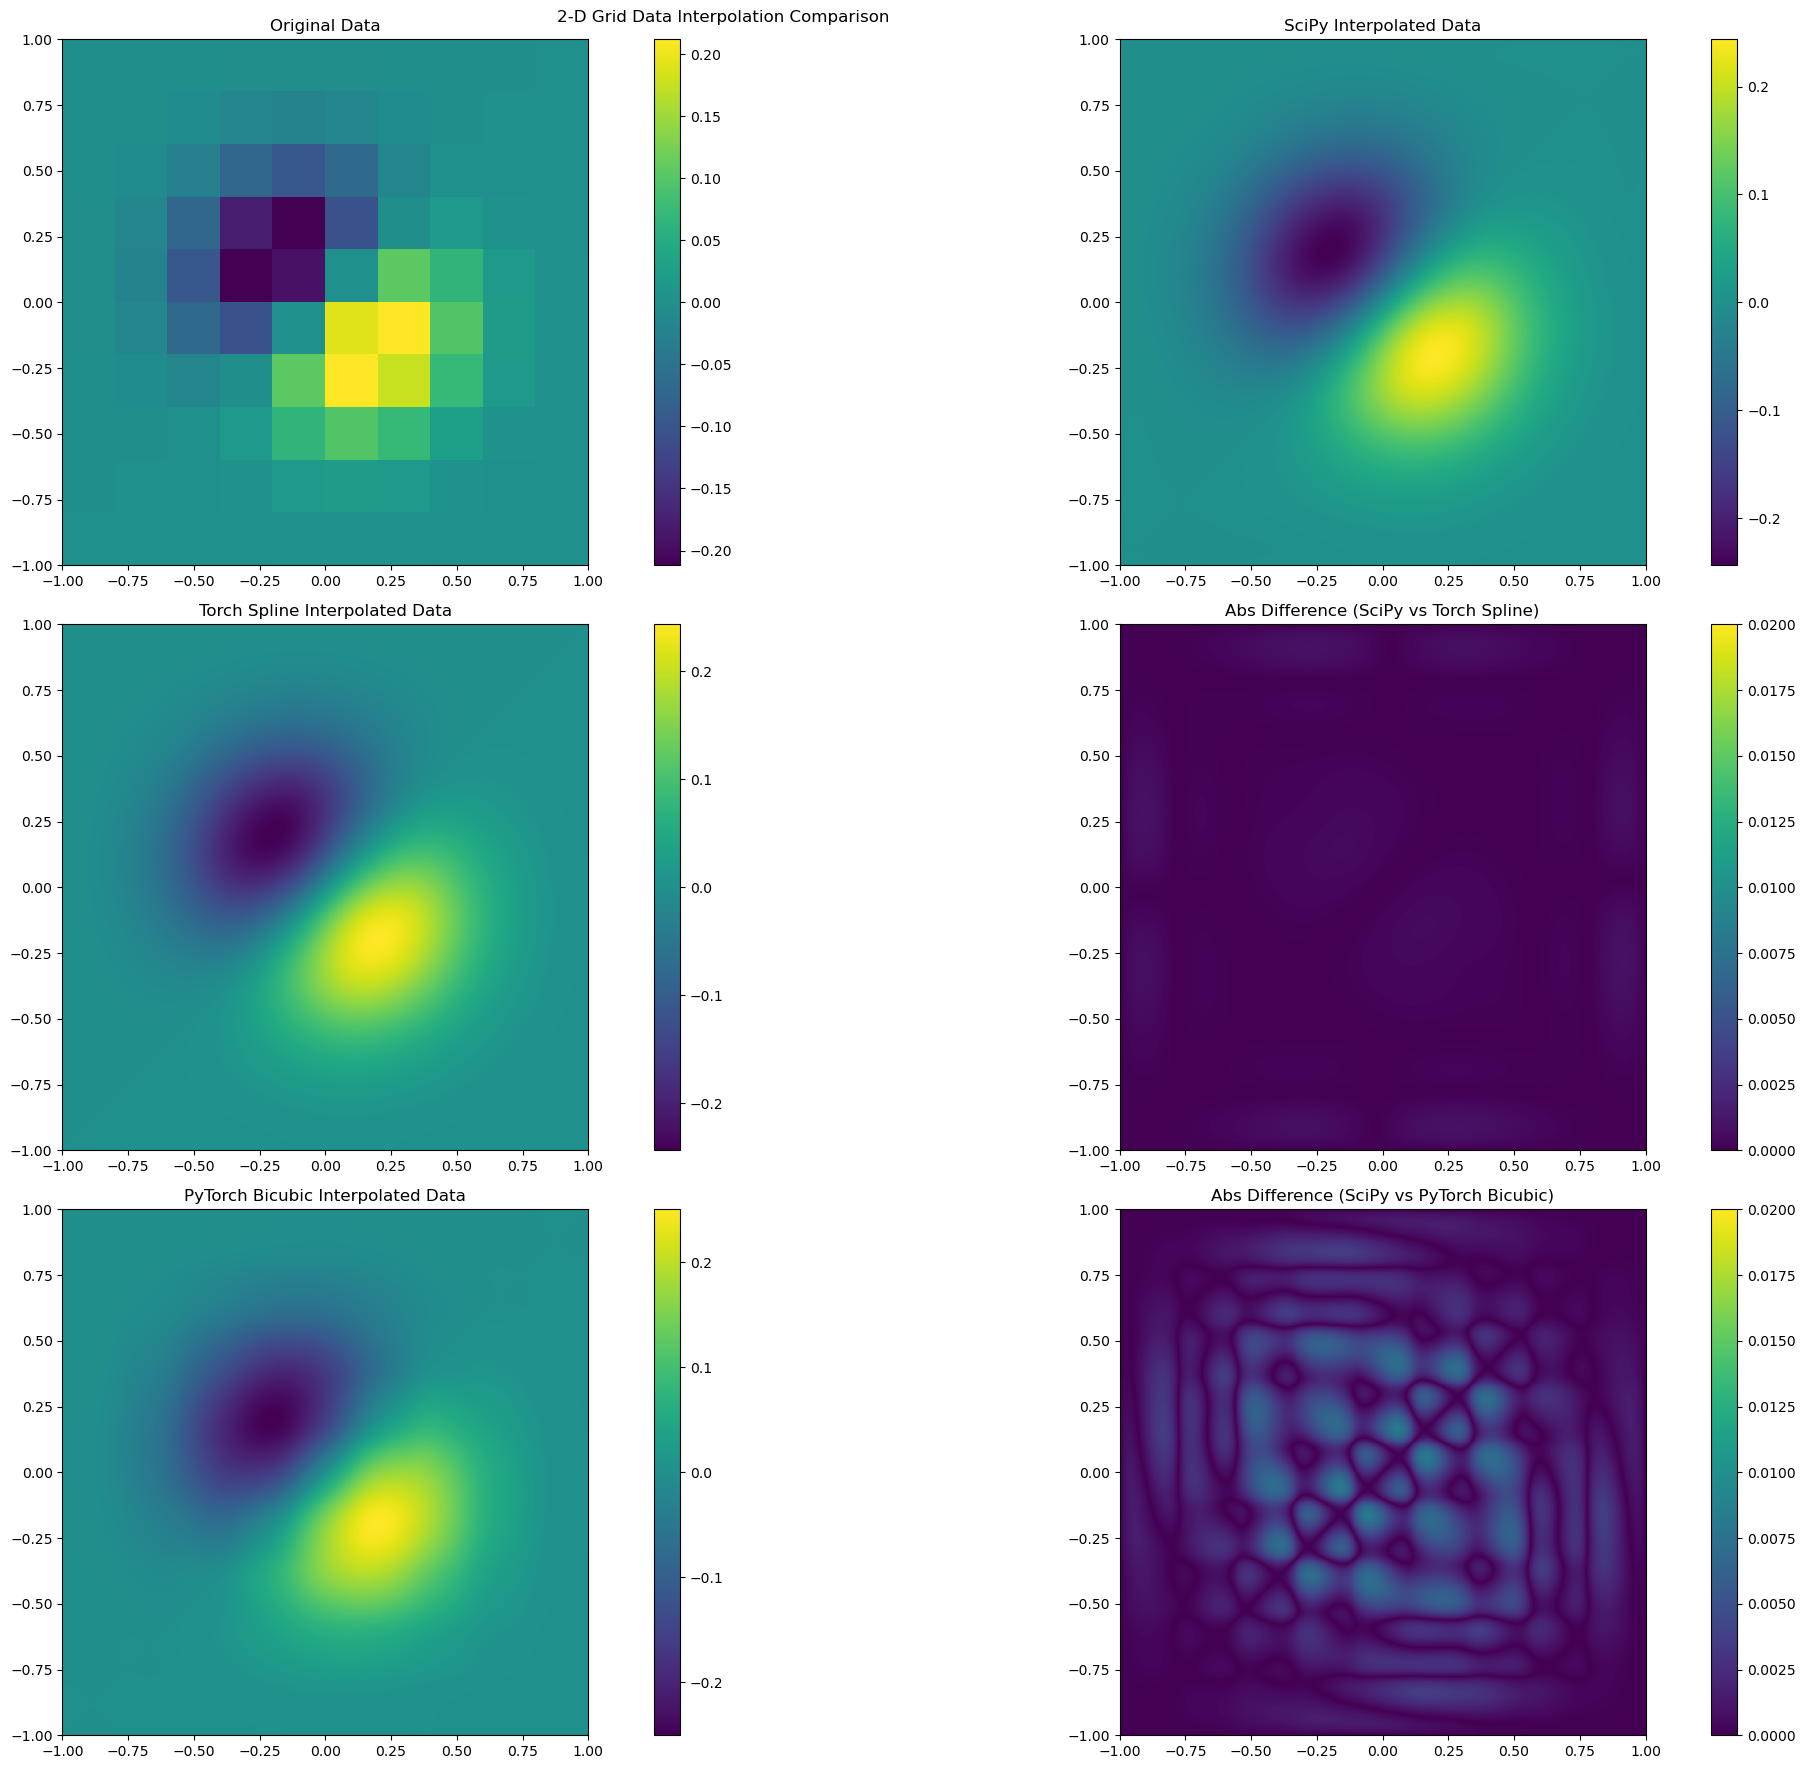

In [23]:
# Generate data
x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)
x_grid, y_grid = np.meshgrid(x, y)
z = (x_grid + y_grid) * np.exp(-6.0 * (x_grid ** 2 + y_grid ** 2))

# Convert numpy arrays to torch tensors
z_torch = torch.from_numpy(z).float()

print(z_torch.shape)

# Fit and evaluate the custom Torch spline interpolation
kx, ky = 3, 3
s = 0.001
start=time.time()
coef, tx, ty = bivariate_spline_fit_natural_torch(torch.tensor(x).float(), torch.tensor(y).float(), z_torch, kx, ky,s)
end=time.time()
print(f'TIME FOR SPLINE FIT: {end-start}s')
# Evaluate the spline on a grid

x_eval = torch.linspace(-1, 1, 400)
y_eval = torch.linspace(-1, 1, 400)
start=time.time()
znew_torch = evaluate_bivariate_spline_torch(x_eval, y_eval, coef, tx, ty, kx, ky).view(400, 400)
end=time.time()
print(f'TIME FOR SPLINE EVALUATION: {end-start}s')
      
# Plotting the results
plt.figure(figsize=(24, 18))

# Plot original data
plt.subplot(3, 2, 1)
im = plt.imshow(z, extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('Original Data')

# Interpolate onto a new grid using SciPy for comparison
f = RectBivariateSpline(x, y, z)
znew_scipy = f(x_eval.numpy(), y_eval.numpy())

# Plot SciPy interpolated data
plt.subplot(3, 2, 2)
im = plt.imshow(znew_scipy, extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('SciPy Interpolated Data')

# Plot Torch spline interpolated data
plt.subplot(3, 2, 3)
im = plt.imshow(znew_torch.detach().numpy(), extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('Torch Spline Interpolated Data')


# Calculate the absolute differences
abs_diff_torch = np.abs(znew_scipy - znew_torch.detach().numpy())

# Plot the absolute difference between SciPy and Torch spline interpolations
plt.subplot(3, 2, 4)
im = plt.imshow(abs_diff_torch, extent=(-1, 1, -1, 1), vmin=0, vmax=0.02)
plt.colorbar(im)
plt.title('Abs Difference (SciPy vs Torch Spline)')

# Perform bicubic interpolation using PyTorch

z_torch_unsqueeze = z_torch.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
znew_bicubic_torch = F.interpolate(z_torch_unsqueeze, size=(400, 400), mode='bicubic', align_corners=True)
znew_bicubic_torch = znew_bicubic_torch.squeeze(0).squeeze(0)  # Remove batch and channel dimensions

# Plot PyTorch bicubic interpolated data
plt.subplot(3, 2, 5)
im = plt.imshow(znew_bicubic_torch.detach().numpy(), extent=(-1, 1, -1, 1))
plt.colorbar(im)
plt.title('PyTorch Bicubic Interpolated Data')

# Calculate the absolute differences
abs_diff_bicubic = np.abs(znew_scipy - znew_bicubic_torch.detach().numpy())

# Plot the absolute difference between SciPy and PyTorch bicubic interpolations
plt.subplot(3, 2, 6)

im = plt.imshow(abs_diff_bicubic, extent=(-1, 1, -1, 1), vmin=0, vmax=0.02)
plt.colorbar(im)
plt.title('Abs Difference (SciPy vs PyTorch Bicubic)')

plt.suptitle('2-D Grid Data Interpolation Comparison')
plt.tight_layout()
plt.show()

## GWs Qplots interpolation

In [2]:
import numpy as np
import h5py as h5
from gwpy.timeseries import TimeSeries
import pandas as pd
from pathlib import Path
from gwpy.timeseries import TimeSeriesDict
#from lalframe.utils.frtools import get_channels
from os import listdir
from gwpy.signal import filter_design
from matplotlib import pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import time
import json
import os
import ERF
import math

In [11]:
import importlib
import sys
from qptransformlinear import *

# Reload the module
importlib.reload(sys.modules['qptransformlinear'])

<module 'qptransformlinear' from '/home/jovyan/qptransformlinear.py'>

In [4]:
import importlib
import sys
from torch_spline_interpolation import *

# Reload the module
importlib.reload(sys.modules['torch_spline_interpolation'])

<module 'torch_spline_interpolation' from '/home/jovyan/torch_spline_interpolation.py'>

In [5]:
# change path to your local folder
file='DdncGnx3ph.h5'
event_id='DdncGnx3ph'
fout=h5.File(file)
strain=fout[event_id]['V1:Hrec_hoft_16384Hz']

#to inspect the file and read aux_channels:
#all_channels=list(fout[event_id])
#all_channels 

sample_rate = 500.0
duration=6

t0=strain.attrs['t0']
print(t0)

tms_strain=TimeSeries(strain, dt=1/strain.attrs['sample_rate'],t0=t0)
tms_strain = tms_strain.resample(sample_rate)
tms_strain=tms_strain.whiten()

#event=tms_strain
event = tms_strain.crop(t0+(16-duration)/2,t0+(16+duration)/2)
print(event)

1241762914.0
TimeSeries([ 1.73771481, -1.34473965, -3.76462878, ...,
            -0.53466477,  2.22083019,  1.4107389 ]
           unit: dimensionless,
           t0: 1241762918.998 s,
           dt: 0.002 s,
           name: None,
           channel: None)


In [6]:
def compute_transforms(event, q=12, frange=(5, 100), sample_rate=500.0, qrange=[4, 64], num_t_bins=1000, fres=0.5,plot=True):
    """
    Compute various types of Q-transforms using both GWpy and PyTorch and visualize the results.

    Inputs:
    - event (TimeSeries): Input time series data.
    - q (float): Q-value for the Q-transform. Default vaule is 12
    - frange (tuple, optional): Frequency range for the Q-transform. Default is (5, 100).
    - sample_rate (float, optional): Sampling rate of the input data. Default is 500.0 Hz.
    - qrange (list, optional): Range of Q-values for the Q-scan. Default is [4, 64].
    - num_t_bins (int, optional): Number of time bins for the Q-transform. Default is 1000.
    - fres (float, optional): Frequency resolution for the Q-transform. Default is 0.5.

    Outputs:
    - gwpy_transform (Spectrogram): GWpy Q-transform with single Q-value.
    - transformed (Tensor): Torch Q-transform with single Q-value.
    - gwpy_transform_multiq (Spectrogram): GWpy Q-transform with multiple Q-values.
    - qtransform_multiq (Tensor): Torch Q-transform with multiple Q-values.

    """
    duration = event.duration.value
    tres = duration / num_t_bins
    num_f_bins = int((frange[1] - frange[0]) / fres)
    f_range = [frange[0], frange[1]]

    # Empty cache
    try:
        torch.cuda.empty_cache()
        print('Cache emptied')
    except:
        pass

    # Compute single Q GWpy Q-transform
    gwpy_transform = event.q_transform(qrange=[q, q], tres=tres, fres=fres, logf=False, whiten=False, frange=frange)

    # Compute multi-Q GWpy Q-transform
    gwpy_transform_multiq = event.q_transform(qrange=[4, 64], tres=tres, fres=fres, logf=False, whiten=False, frange=frange)

    # Compute default parameter choice GWpy Q-transform
    gwpy_transform_default = event.q_transform(whiten=False, frange=frange)

    # Compute Torch single Q Q-transform
    try:
        qtransform = SingleQTransformLinear(sample_rate=sample_rate, duration=duration, q=q, frange=frange).to(device)
    except:
        qtransform = SingleQTransform(sample_rate=sample_rate, duration=duration, q=q, frange=frange).to(device)

    transformed = qtransform(torch.Tensor(event.value).to(device), num_f_bins=num_f_bins, num_t_bins=num_t_bins)

    if plot:
        # Compute differences between Torch and GWpy Q-transforms
        abs_diff = abs(transformed.detach().cpu().numpy() - gwpy_transform.value.T)
    
        # Plot Q-transforms
        fig, axes = plt.subplots(1, 3, figsize=(20, 20))
        im0 = axes[0].imshow(gwpy_transform.value.T, aspect="auto", origin="lower", vmin=0, vmax=25)
        axes[0].set_title("GWpy  single q")
        fig.colorbar(im0, ax=axes[0])
    
        im1 = axes[1].imshow(transformed.cpu().numpy(), aspect="auto", origin="lower", vmin=0, vmax=25)
        axes[1].set_title("Torch single q")
        fig.colorbar(im1, ax=axes[1])
    
        im2 = axes[2].imshow(abs_diff, aspect="auto", origin="lower", vmin=0, vmax=25)
        axes[2].set_title("Abs Difference gwpy/ torch")
        fig.colorbar(im2, ax=axes[2])
    
    
        plt.show()
    
        #print out some stats
        print(f'SIZE GWPY: {gwpy_transform.value.T.shape}')
        print(f'SIZE GWPY default: {gwpy_transform_default.value.T.shape}')
        print(f'SIZE TORCH: {transformed.shape}')
        print(f'MAX VALUE OF GWPY: {np.max(gwpy_transform.value.T)}')
        print(f'MAX VALUE OF TORCH: {np.max(transformed.cpu().numpy())}')
        print(f'MEAN OF TORCH PLOT: {np.mean(transformed.cpu().numpy())}; STD: {np.std(transformed.cpu().numpy())}')
        print(f'MEAN OF GWPY PLOT: {np.mean(gwpy_transform.value.T)}; STD: {np.std(gwpy_transform.value.T)}')
        print(f'MEAN OF ABS DIFF PLOT: {np.mean(abs_diff)}; STD: {np.std(abs_diff)} ')
        
        return gwpy_transform,transformed
    else:
        return gwpy_transform,transformed

In [7]:
q = 12 #5.65685424949238 #12
num_t_bins=200
fres = 0.5
frange=(10,100)
qrange=[12,12]

In [12]:
start=time.time() 
gwpy_transform,transformed=compute_transforms(event, q=q, frange=frange, sample_rate=sample_rate, qrange=qrange, num_t_bins=num_t_bins, fres=fres)
end=time.time()
print(f'Total time: {end-start}s')

Cache emptied
type(self.qtiles)=<class 'list'>
Number of time bins: 200
x_bins=1024
Shape after time dimension interpolation: torch.Size([175, 1024])


OutOfMemoryError: CUDA out of memory. Tried to allocate 121.23 GiB (GPU 0; 39.42 GiB total capacity; 27.64 MiB already allocated; 38.00 GiB free; 42.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# Compute differences between Torch and GWpy Q-transforms
abs_diff = abs(transformed.detach().cpu().numpy() - gwpy_transform.value)

# Plot Q-transforms
fig, axes = plt.subplots(1, 3, figsize=(20, 9))
im0 = axes[0].imshow(gwpy_transform.value, aspect="auto", origin="lower", vmin=0, vmax=25)
axes[0].set_title("GWpy  single q")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(transformed.cpu().numpy(), aspect="auto", origin="lower", vmin=0, vmax=25)
axes[1].set_title("Torch single q")
fig.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(abs_diff, aspect="auto", origin="lower", vmin=0, vmax=25)
axes[2].set_title("Abs Difference gwpy/ torch")
fig.colorbar(im2, ax=axes[2])


plt.show()

In [ ]:
def compute_transforms(event, q=12, frange=(5, 100), sample_rate=500.0, qrange=[4, 64], num_t_bins=1000, fres=0.5):
    """
    Compute various types of Q-transforms using both GWpy and PyTorch and visualize the results.

    Inputs:
    - event (TimeSeries): Input time series data.
    - q (float): Q-value for the Q-transform. Default vaule is 12
    - frange (tuple, optional): Frequency range for the Q-transform. Default is (5, 100).
    - sample_rate (float, optional): Sampling rate of the input data. Default is 500.0 Hz.
    - qrange (list, optional): Range of Q-values for the Q-scan. Default is [4, 64].
    - num_t_bins (int, optional): Number of time bins for the Q-transform. Default is 1000.
    - fres (float, optional): Frequency resolution for the Q-transform. Default is 0.5.

    Outputs:
    - gwpy_transform (Spectrogram): GWpy Q-transform with single Q-value.
    - transformed (Tensor): Torch Q-transform with single Q-value.
    - gwpy_transform_multiq (Spectrogram): GWpy Q-transform with multiple Q-values.
    - qtransform_multiq (Tensor): Torch Q-transform with multiple Q-values.

    """
    duration = event.duration.value
    tres = duration / num_t_bins
    num_f_bins = int((frange[1] - frange[0]) / fres)
    f_range = [frange[0], frange[1]]

    # Empty cache
    try:
        torch.cuda.empty_cache()
        print('Cache emptied')
    except:
        pass

    # Compute single Q GWpy Q-transform
    gwpy_transform = event.q_transform(qrange=[q, q], tres=tres, fres=fres, logf=False, whiten=False, frange=frange)

    # Compute multi-Q GWpy Q-transform
    gwpy_transform_multiq = event.q_transform(qrange=[4, 64], tres=tres, fres=fres, logf=False, whiten=False, frange=frange)

    # Compute default parameter choice GWpy Q-transform
    gwpy_transform_default = event.q_transform(whiten=False, frange=frange)

    # Compute Torch single Q Q-transform
    try:
        qtransform = SingleQTransformLinear(sample_rate=sample_rate, duration=duration, q=q, frange=frange).to(device)
    except:
        qtransform = SingleQTransform(sample_rate=sample_rate, duration=duration, q=q, frange=frange).to(device)

    transformed = qtransform(torch.Tensor(event.value).to(device), num_f_bins=num_f_bins, num_t_bins=num_t_bins)

    # Perform the Q-scan on the signal data
    qscan = QScan(duration=duration, sample_rate=sample_rate, qrange=qrange, frange=f_range).to(device)

    try:
        qtransform_multiq, selected_q = qscan(torch.Tensor(event.value).to(device), num_f_bins=num_f_bins,
                                              num_t_bins=num_t_bins)
        print("Selected Q value:", selected_q)
    except:
        qtransform_multiq = qscan(torch.Tensor(event.value).to(device), num_f_bins=num_f_bins, num_t_bins=num_t_bins)

    # Compute differences between Torch and GWpy Q-transforms
    abs_diff = abs(transformed.detach().cpu().numpy() - gwpy_transform.value.T)
    abs_diff_multiq = abs(qtransform_multiq.detach().cpu().numpy() -  gwpy_transform_multiq.value.T)

    # Plot Q-transforms
    fig, axes = plt.subplots(2, 3, figsize=(20, 9))
    im0 = axes[0, 0].imshow(gwpy_transform.value.T, aspect="auto", origin="lower", vmin=0, vmax=25)
    axes[0, 0].set_title("GWpy  single q")
    fig.colorbar(im0, ax=axes[0, 0])

    im1 = axes[0, 1].imshow(transformed.cpu().numpy(), aspect="auto", origin="lower", vmin=0, vmax=25)
    axes[0, 1].set_title("Torch single q")
    fig.colorbar(im1, ax=axes[0, 1])

    im2 = axes[0, 2].imshow(abs_diff, aspect="auto", origin="lower", vmin=0, vmax=25)
    axes[0, 2].set_title("Abs Difference gwpy/ torch")
    fig.colorbar(im2, ax=axes[0, 2])

    im3 = axes[1, 0].imshow(gwpy_transform_default.value.T, aspect="auto", origin="lower", vmin=0, vmax=25)
    axes[1, 0].set_title("GWpy default")
    fig.colorbar(im2, ax=axes[1, 0])

    im4 = axes[1, 1].imshow(qtransform_multiq.cpu().numpy(), aspect="auto", origin="lower", vmin=0, vmax=25)
    axes[1, 1].set_title("Torch multi q")
    fig.colorbar(im2, ax=axes[1, 1])

    im5 = axes[1, 2].imshow(abs_diff_multiq, aspect="auto", origin="lower", vmin=0, vmax=25)
    axes[1, 2].set_title("Abs Difference gwpy default - torch multiq")
    fig.colorbar(im2, ax=axes[1, 2])

    plt.show()

    #print out some stats
    print(f'SIZE GWPY: {gwpy_transform.value.T.shape}')
    print(f'SIZE GWPY default: {gwpy_transform_default.value.T.shape}')
    print(f'SIZE TORCH: {transformed.shape}')
    print(f'MAX VALUE OF GWPY: {np.max(gwpy_transform.value.T)}')
    print(f'MAX VALUE OF TORCH: {np.max(transformed.cpu().numpy())}')
    print(f'MEAN OF TORCH PLOT: {np.mean(transformed.cpu().numpy())}; STD: {np.std(transformed.cpu().numpy())}')
    print(f'MEAN OF GWPY PLOT: {np.mean(gwpy_transform.value.T)}; STD: {np.std(gwpy_transform.value.T)}')
    print(f'MEAN OF ABS DIFF PLOT: {np.mean(abs_diff)}; STD: {np.std(abs_diff)} ')
    print(f'MEAN OF ABS DIFF GWPY PLOT: {np.mean(abs_diff_multiq)}; STD: {np.std(abs_diff_multiq)} ')
    
    return gwpy_transform,transformed,gwpy_transform_multiq,qtransform_multiq